# Importing libraries

In [ ]:
import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os

from torch.utils.data import TensorDataset, DataLoader, random_split
from urllib.request import urlretrieve
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

# Dataset preprocessing

In [ ]:
class MaskImageDataset:
    """
    Basic class to download clean images and generate masks.
    """

    def __init__(self, from_file=None):
        """
        Load dataset from file if specified.
        Otherwise automaticly download and create from scratch.
        """

        if not from_file is None:
            self.load_dataset(from_file)
            return
        # Load some images
        self.images = self.load_images()
        # Add masks to images
        self.masked_images = torch.cat(
            [self.mask_image(image).unsqueeze(0) for image in self.images]
            , dim=0)

    def load_images(self) -> torch.Tensor:
        """
        Load image from the internet.
        """
        return torch.tensor([])

    def mask_image(self, image: torch.Tensor) -> torch.Tensor:
        """
        Create a mask for image.
        """
        return image

    def get_image(self, index):
        """
        Give image by index.
        """
        return self.images[index]

    def get_masked_image(self, index):
        """
        Give image with mask by index.
        """
        return self.masked_images[index]

    def save_dataset(self, filename="dataset.pt"):
        """
        Save any dataset to a file.
        """
        torch.save({
            "images": self.images,
            "masked_images": self.masked_images
        }, filename)

    def load_dataset(self, filename="dataset.pt"):
        """
        Load a dataset from a file.
        """
        dataset = torch.load(filename)
        self.images = dataset["images"]
        self.masked_images = dataset["masked_images"]

    def pack_to_dataloaders(self, batch_size=32, train_fraction=0.7) -> tuple[DataLoader, DataLoader]:
        """
        Pack image data into dataloaders for model training.
        """
        images_dataset = TensorDataset(self.masked_images, self.images)
        images_train, images_val = random_split(images_dataset, [train_fraction, 1-train_fraction])
        return (DataLoader(images_train, batch_size=batch_size, shuffle=False),
                DataLoader(images_val, batch_size=batch_size, shuffle=True))


In [ ]:
class CIFAR10Masked(MaskImageDataset):
    """
    CIFAR10 dataset with 32x32 RGB images.
    """

    def load_images(self) -> np.array:
        # Load images using keras
        (images1, _), (images2, _) = tf.keras.datasets.cifar10.load_data()
        return torch.cat((torch.tensor(images1), torch.tensor(images2)), dim=0)

    def mask_image(self, image: torch.Tensor) -> np.array:
        # Generate random top-left coordinates.
        x1, y1 = np.random.randint(0, 26, size=2)
        # Generate random bottom-right coordinates
        min_w, min_h, max_w, max_h = 5, 5, 9, 9
        x2 = np.random.randint(min(x1+min_w,32), min(x1+max_w,32))
        y2 = np.random.randint(min(y1+min_h,32), min(y1+max_h,32))
        # Copy original image
        masked_image = image.clone().detach()
        # Fill black rectange on generated coordinates
        mask = torch.tensor(np.zeros((y2-y1)*(x2-x1)*3).reshape(y2-y1,x2-x1,3))
        masked_image[y1:y2,x1:x2] = mask
        # Return result
        return masked_image

170498071/170498071 [==============================] - 4s 0us/step


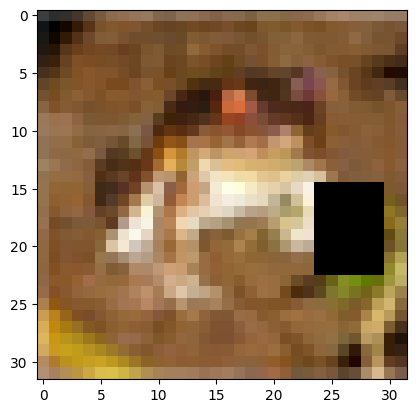

In [ ]:
# Test for CIFAR10
cifar10_test = CIFAR10Masked()
train_loader, test_loader = cifar10_test.pack_to_dataloaders()
cifar10_test.save_dataset(filename="cifar10.pt")

plt.imshow(cifar10_test.get_masked_image(0))

In [17]:
# From hugging face
class AquaMagicBrushMasked(MaskImageDataset):
    """
    Dataset that was used to train Aqua Magic Brush.
    """

    def __init__(self):
        self.images, self.masked_images = self.load_images()

    def load_images(self) -> np.array:
        # WARNING: If you want to add 'filtered' or 'extra' .parquet files. Do not do this.
        # Extra - are unfiltered.
        # Filtered - are filtered only from humans.
        urls = [
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00000-of-00004-e162115722f1be56.parquet",
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00001-of-00004-d51ef97cecd37906.parquet",
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00002-of-00004-e1736c6f52875d53.parquet",
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00003-of-00004-93e3835eaca42171.parquet"
        ]

        mask_images = []
        images = []
        self.test_im = None

        for i, url in enumerate(urls):
            if not os.path.isfile(f"dev{i+1}.parquet"):
                print(f"Downloading {i+1}/{len(urls)}")
                urlretrieve(url, f"dev{i+1}.parquet")
            print(f"Parsing {i+1}/{len(urls)}")
            data = pd.read_parquet(f"dev{i+1}.parquet")
            for entry in data["source_img"]:
                image = Image.open(io.BytesIO(entry["bytes"]))
                if self.test_im == None:
                    self.test_im = image.resize((500, 500)).convert('RGB')
                image = image.resize((500, 500)).convert('RGB') # All images must have equal size? (временно)
                images.append(torch.tensor(np.asarray(image)).unsqueeze(0))

            for entry in data["mask_img"]:
                mask_image = Image.open(io.BytesIO(entry["bytes"]))
                mask_image = mask_image.resize((500, 500)).convert('RGB')
                mask_images.append(torch.tensor(np.asarray(mask_image)).unsqueeze(0))

        return torch.cat(images, dim=0), torch.cat(mask_images, dim=0)

Parsing 1/4
Parsing 2/4
Parsing 3/4
Parsing 4/4


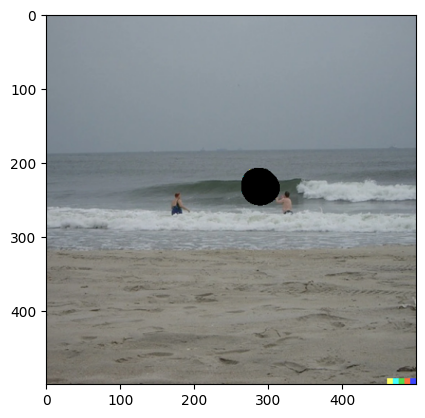

In [21]:
# Test for Aqua Magic Brush dataset
aqua_test = AquaMagicBrushMasked()
train_loader, test_loader = aqua_test.pack_to_dataloaders()
aqua_test.save_dataset(filename="aqua.pt")

plt.imshow(aqua_test.get_masked_image(0).view(500, 500, 3))

In [ ]:
# Implement if you want XD
class ImageNetMasked(MaskImageDataset):
    """
    Description
    """

    def load_images(self) -> np.array:
        pass

    def mask_image(self, image: np.array) -> np.array:
        pass

In [ ]:
# Test for ImageNet

Implement other dataset if you want. Please follow format for easier development.

# Model(s)

In [ ]:
# Will be done in future

# Training loop

In [ ]:
# Will be done in future

# Test and evaluation

In [ ]:
# Will be done in future